# GHZ Game

### 0. Imports

In [9]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit.visualization import circuit_drawer, plot_histogram
from qiskit.providers.basic_provider import BasicProvider

import matplotlib.pyplot as plt
import random

### 1. Spielregeln

1. Spieler Alice, Bob & Clara sind voneinander getrennt und können nicht kommunizieren

2. Jeder wird entweder nach einer Form (Stern oder Rechteck) oder einer Farbe (rot oder blau) gefragt

3. Dabei können nur folgende Konstellationen auftreten 
    - Farbe, Farbe, Farbe
    - Form, Farbe, Farbe
    - Farbe, Form, Farbe
    - Farbe, Farbe, Form

4. Gewonnen haben Alice, Bob & Clara, wenn entweder
    - bei 3x Farbe eine gerade Anzahl oft rot genannt wurde
    - bei 2x Farbe + 1x Form eine ungerade Anzahl oft rot und Stern kombiniert genannt wurden

In [3]:
def get_mode():
    return random.choice(['ccc', 'scc', 'csc', 'ccs']) #c steht für color, s für shape

def choose_color_shape(manual=False):
    if manual:
        color = input('Choose color (red/blue): ')
        shape = input('Choose shape (star/rectangle): ')
        return {'c': color, 's': shape}
    else:
        color = random.choice(['red', 'blue'])
        shape = random.choice(['star', 'rectangle'])
        return {'c': color, 's': shape}

def check_win(players, mode = None, print_mode = False):
    if mode is None:
        mode = get_mode()
    if print_mode:
        print(mode)

    if mode == 'ccc':
        #zähle die anzahl an "rot" und gib "True" zurück, wenn die Anzahl gerade ist
        red = 0
        for player in players:
            if print_mode:
                print(player,":",players[player]['c'])
            if players[player]['c'] == 'red': 
                red += 1
        if red %2 == 0:
            return True
        else:
            return False	
        
    else:
        #zähle die Anzahl von rot und Sternen und gib "True" zurück, wenn die Anzahl ungerade ist
        red = 0
        star = 0       
        i = 0  

        for player in players:
            m = mode[i]
            if print_mode:
                print(player,":",players[player][m])
            if players[player][m] == 'red':
                red += 1
            if players[player][m] == 'star':
                star += 1

            i += 1
        
        if (red+star) %2 == 0:
            return False
        else:
            return True

### 2. Klassische Strategie

In [4]:
players = {}
for p in ["a", "b", "c"]:
    players[p] = choose_color_shape() #kann auf manuell umgestellt werden


print(check_win(players, mode='ccc', print_mode=True)) #mode kann manuell gesetzt werden, Format: 'ccc' oder 'scc' oder 'csc' oder 'ccs'

ccc
a : blue
b : blue
c : red
False


Lasst uns das Spiel n-mal mit einer randomisierten Auswahl simulieren, um die Gewinnchancen auszurechnen.  

In [5]:
n = 10000

results = []


for i in range(n):
    players = {}
    for p in ["a", "b", "c"]:
        players[p] = choose_color_shape()

    mode = get_mode()

    win = check_win(players, mode)

    results.append((players,mode, win))

Winning probability:  0.5031
{'csc': 2561, 'ccs': 2498, 'scc': 2475, 'ccc': 2466}


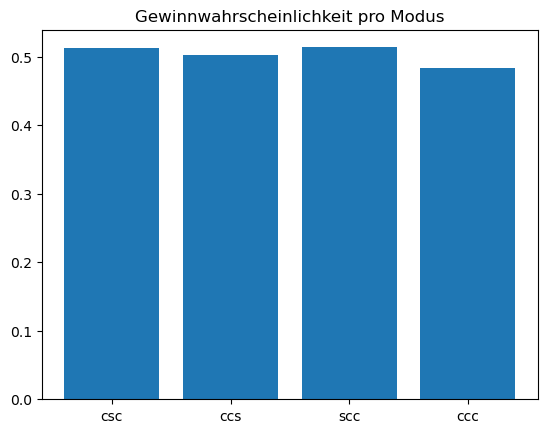

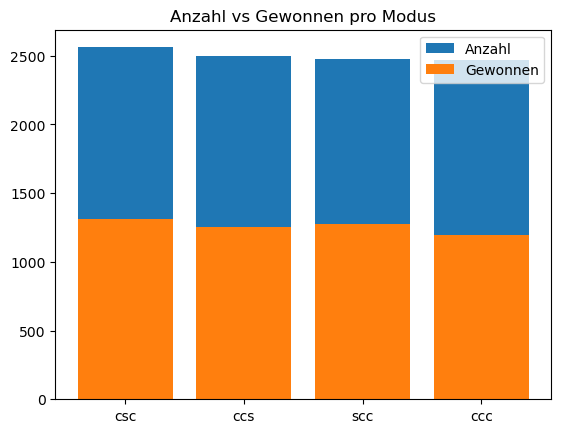

In [6]:
#Gewinnwahrscheinlichkeit berechnen
winners = [r[2] for r in results]
print("Winning probability: ",sum(winners)/n)

#Modi zählen
modes = [r[1] for r in results]
mode_counts = {m:modes.count(m) for m in set(modes)}
print(mode_counts)

#Gewinne pro Modus zählen
mode_wins = {}
for m in mode_counts.keys():
    mode_wins[m] = 0
    for r in results:
        if r[1] == m and r[2]:
            mode_wins[m] += 1

#Gewinnwahrscheinlichkeit pro Modus berechnen
mode_win_prob = {m:mode_wins[m]/mode_counts[m] for m in mode_counts.keys()}

#Die Simulationsergebnisse als Diagramme darstellen

fig, ax = plt.subplots()

ax.bar(mode_win_prob.keys(), mode_win_prob.values())
ax.set_title('Gewinnwahrscheinlichkeit pro Modus')

fig, ax = plt.subplots()

ax.bar(mode_counts.keys(), mode_counts.values(), label='Anzahl')
ax.bar(mode_wins.keys(), [mode_wins[m] for m in mode_counts.keys()], label='Gewonnen')
ax.legend()
ax.set_title('Anzahl vs Gewonnen pro Modus')


plt.show()





### 3. Quanten Strategie

Code ab hier nach J. Lahmann: https://github.com/JanLahmann/Fun-with-Quantum/blob/master/GHZ-Game.ipynb

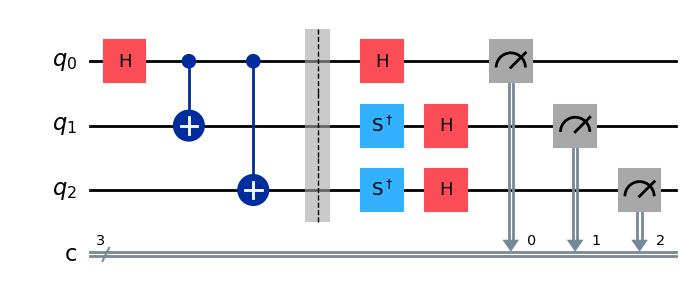

In [20]:
qr = QuantumRegister(3, 'q')
cr = ClassicalRegister(3, 'c')
qc = QuantumCircuit(qr, cr)

qc.h(qr[0])
qc.cx(qr[0], qr[1])
qc.cx(qr[0], qr[2])
qc.barrier()

qc.h(qr[0])
qc.sdg(qr[1])
qc.h(qr[1])
qc.sdg(qr[2])
qc.h(qr[2])

qc.measure(qr,cr)
qc.draw(output='mpl')

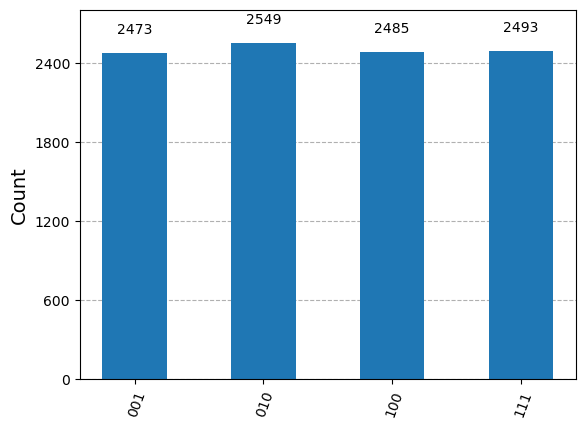

In [21]:
backend = BasicProvider().get_backend("basic_simulator")

result_sim = backend.run(qc, shots=10000).result()
  
counts = result_sim.get_counts(qc)

plot_histogram(counts)